Fundamentos de analítica 2 (clase 4) - Diego Fernando Agudelo - Universidad ICESI - diegoagudelo30@gmail.com

# Fundamentos-analitica-II
Repositorio de trabajos para la asignatura de la maestría en Ciencia de Datos

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS 
APLICADAS 
MAESTRÍA EN CIENCIA DE DATOS 
TIC 60153 – Fundamentos de analítica II 

Grupo: 

**DANIEL DELGADO - FABIAN SALAZAR FIGUEROA**

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 15 de Septiembre a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo csv. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/UNIDAD%20I/Clase%204/Examen.csv", sep=',')
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


(127, 3)


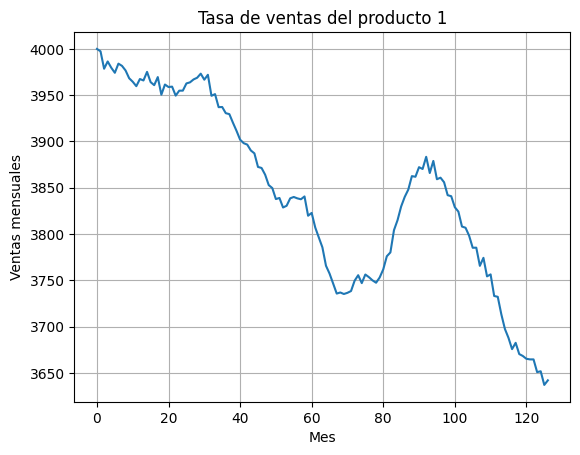

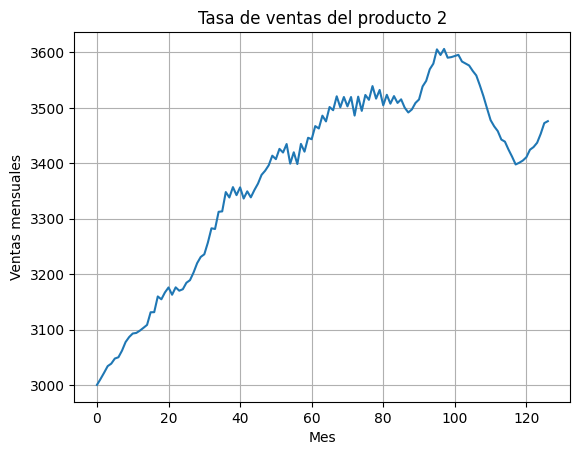

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

## **3. EDA**

### 3.1 Procedemos a hacer un análisis corto de EDA para verificar tamaño del conjunto de datos para cada serie de tiempo, nulos (si hay) y algunas cuantificaciones estadísticas

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    int64  
 1   producto1   127 non-null    float64
 2   producto2   127 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [5]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

Unnamed: 0    0
producto1     0
producto2     0
dtype: int64

In [6]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,Unnamed: 0,producto1,producto2
count,127.000000,127.000000,127.000000
mean,64.000000,3843.571660,3381.037664
std,36.805797,100.234821,167.504363
min,1.000000,3637.047639,3000.000000
25%,32.500000,3756.853812,3269.194001
50%,64.000000,3840.644019,3426.048401
75%,95.500000,3950.071775,3508.941718
max,127.000000,4000.000000,3606.440615


### 3.2 Ahora debemos convertir en índice la variable sin nombre: 'Unnamed: 0'  que representa los meses desde enero del 2008 como lo indica el enunciado del problema y expresarla en forma de fecha para mejorar el entendimiento y procesamiento

In [7]:
# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Función para convertir un número de mes a una fecha
def convertir_mes_a_fecha(mes, start_date):
    # Calcular el año y el mes correspondientes
    year = start_date.year + (mes - 1) // 12
    month = (start_date.month + (mes - 1) % 12 - 1) % 12 + 1
    return datetime(year, month, 1)

# Fecha de inicio (enero de 2008)
start_date = datetime(2008, 1, 1)

# Aplicar la función a la columna 'Mes'
data['Mes'] = data['Mes'].apply(lambda x: convertir_mes_a_fecha(x, start_date))

print(data)


           Mes    producto1    producto2
0   2008-01-01  4000.000000  3000.000000
1   2008-02-01  3997.400893  3010.686220
2   2008-03-01  3978.605317  3022.018584
3   2008-04-01  3986.454125  3033.920990
4   2008-05-01  3979.695678  3038.402098
..         ...          ...          ...
122 2018-03-01  3664.610771  3429.293034
123 2018-04-01  3650.881839  3437.099467
124 2018-05-01  3651.788470  3453.155282
125 2018-06-01  3637.047639  3472.528345
126 2018-07-01  3641.990873  3476.058092

[127 rows x 3 columns]


In [8]:
# Establecer la columna 'Mes' como índice
data.set_index('Mes', inplace=True)

print(data)

              producto1    producto2
Mes                                 
2008-01-01  4000.000000  3000.000000
2008-02-01  3997.400893  3010.686220
2008-03-01  3978.605317  3022.018584
2008-04-01  3986.454125  3033.920990
2008-05-01  3979.695678  3038.402098
...                 ...          ...
2018-03-01  3664.610771  3429.293034
2018-04-01  3650.881839  3437.099467
2018-05-01  3651.788470  3453.155282
2018-06-01  3637.047639  3472.528345
2018-07-01  3641.990873  3476.058092

[127 rows x 2 columns]


In [9]:
#miramos nuevamente como queda el dataframe con estas transformaciones
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2008-01-01 to 2018-07-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [10]:
data.shape

(127, 2)

In [11]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

producto1    0
producto2    0
dtype: int64

In [12]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


### 3.3 Ya con esta pequeñas transformaciones tenemos nuestro conjunto de datos listo para trabajarlo y proceder a hacer todo lo necesario para llevar a cabo los pronósticos de cada serie de tiempo de los dos prodcutos estrellas de la empresa

(127, 2)


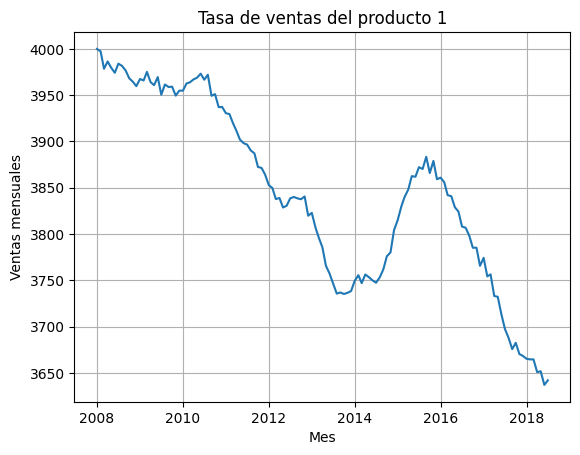

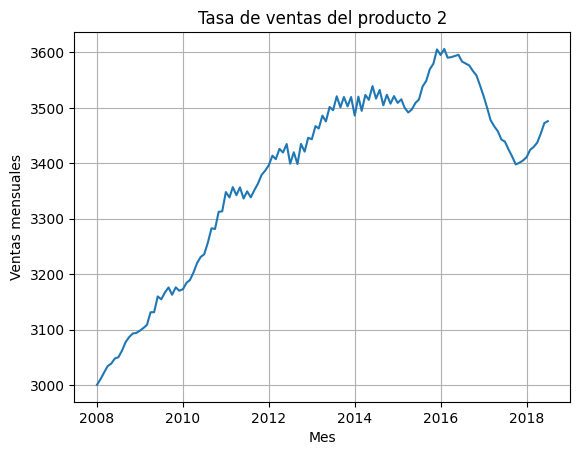

In [13]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

### 3.4 Encontrando los componentes de las series de tiempo para los productos 1 y 2

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

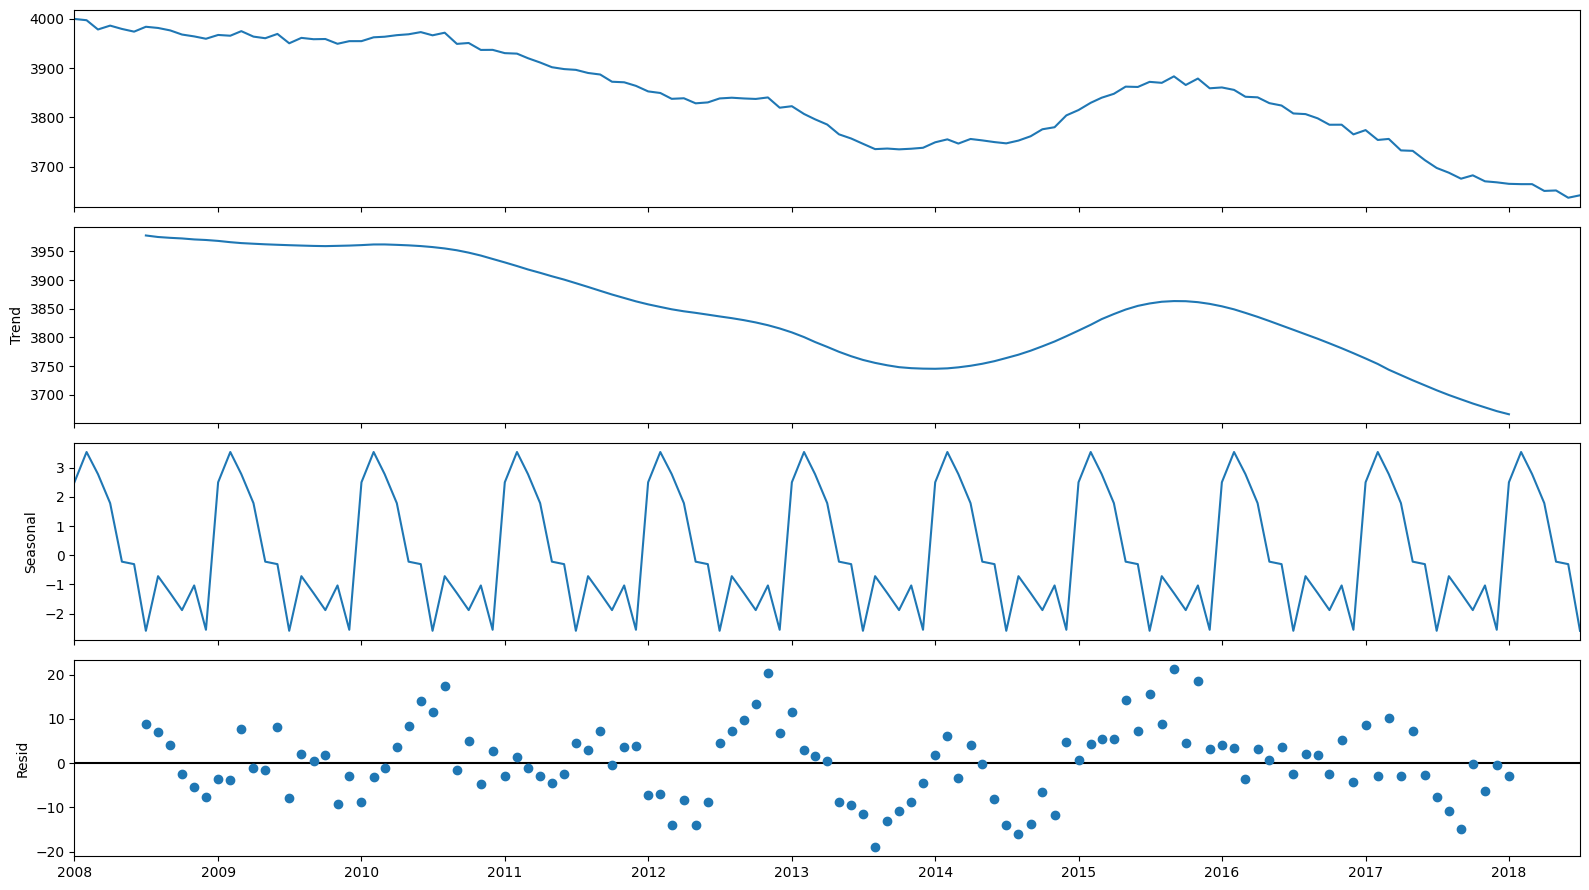

In [14]:
#Componentes serie de tiempo prodcuto1
td_componentes_producto1 = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes_producto1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie de producto1, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto1

In [15]:
td_componentes_producto1.seasonal

Mes
2008-01-01    2.495315
2008-02-01    3.531537
2008-03-01    2.775396
2008-04-01    1.781834
2008-05-01   -0.220084
                ...   
2018-03-01    2.775396
2018-04-01    1.781834
2018-05-01   -0.220084
2018-06-01   -0.304548
2018-07-01   -2.585303
Name: seasonal, Length: 127, dtype: float64

In [16]:
td_componentes_producto1.trend

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: trend, Length: 127, dtype: float64

In [17]:
td_componentes_producto1.resid

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: resid, Length: 127, dtype: float64

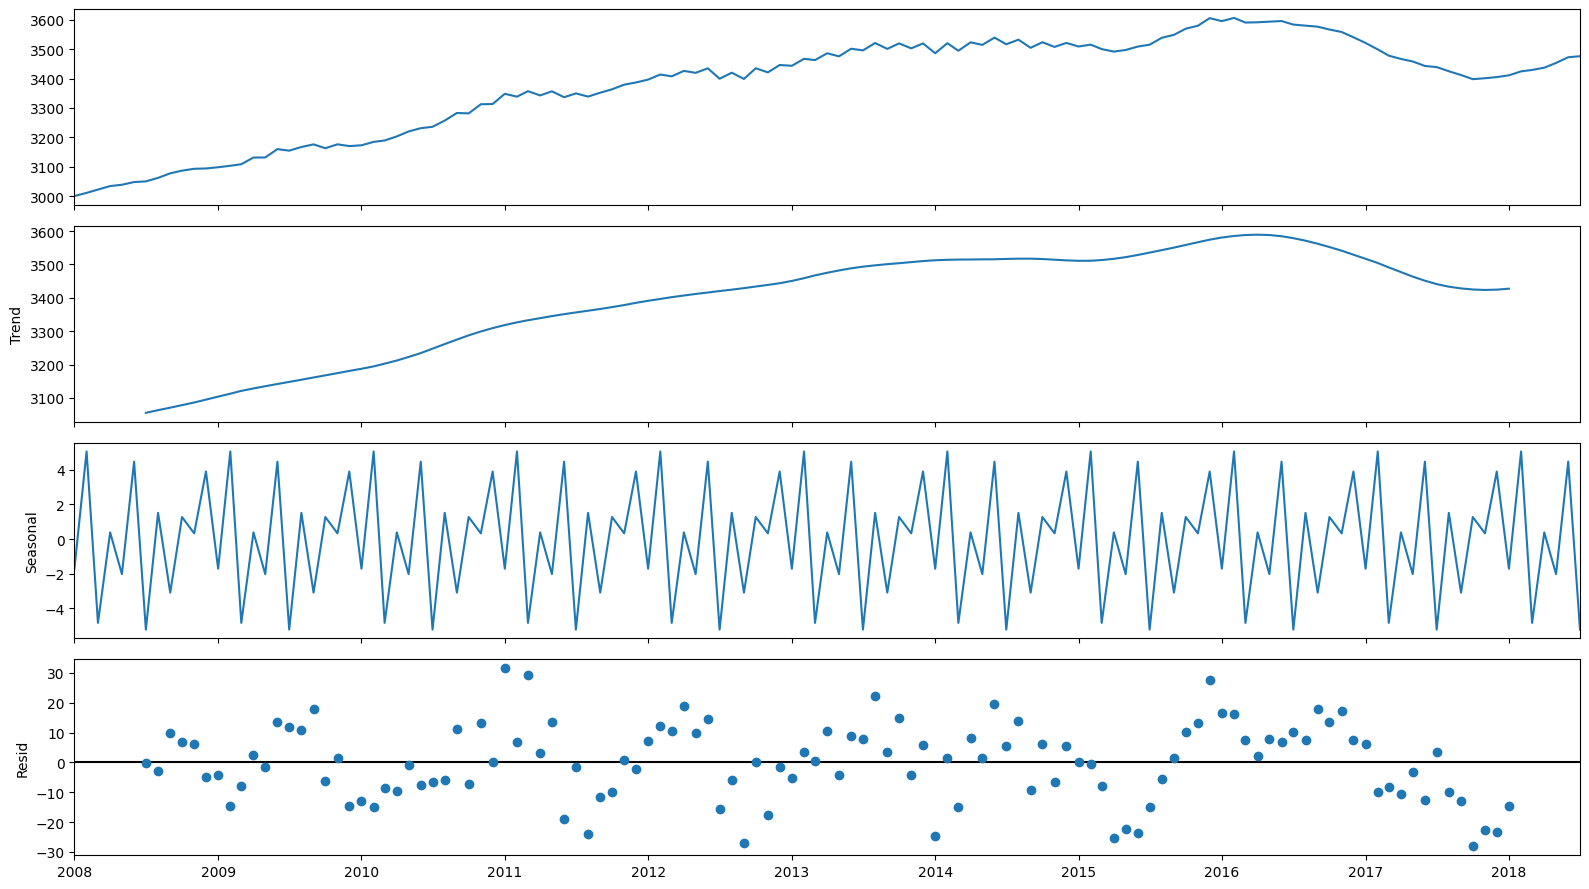

In [18]:
#Componentes serie de tiempo prodcuto2
td_componentes_producto2 = seasonal_decompose(data[["producto2"]],model="additive")
fig = td_componentes_producto2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie producto2, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto2

In [19]:
td_componentes_producto2.seasonal

Mes
2008-01-01   -1.709341
2008-02-01    5.041275
2008-03-01   -4.827994
2008-04-01    0.382215
2008-05-01   -2.021890
                ...   
2018-03-01   -4.827994
2018-04-01    0.382215
2018-05-01   -2.021890
2018-06-01    4.453935
2018-07-01   -5.214986
Name: seasonal, Length: 127, dtype: float64

In [20]:
td_componentes_producto2.trend

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: trend, Length: 127, dtype: float64

In [21]:
td_componentes_producto2.resid

Mes
2008-01-01   NaN
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
              ..
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
Name: resid, Length: 127, dtype: float64

Procedemos a realizar una gráfica para comparar ambas series donde vemos el comportamiento de cada producto respecto al otro

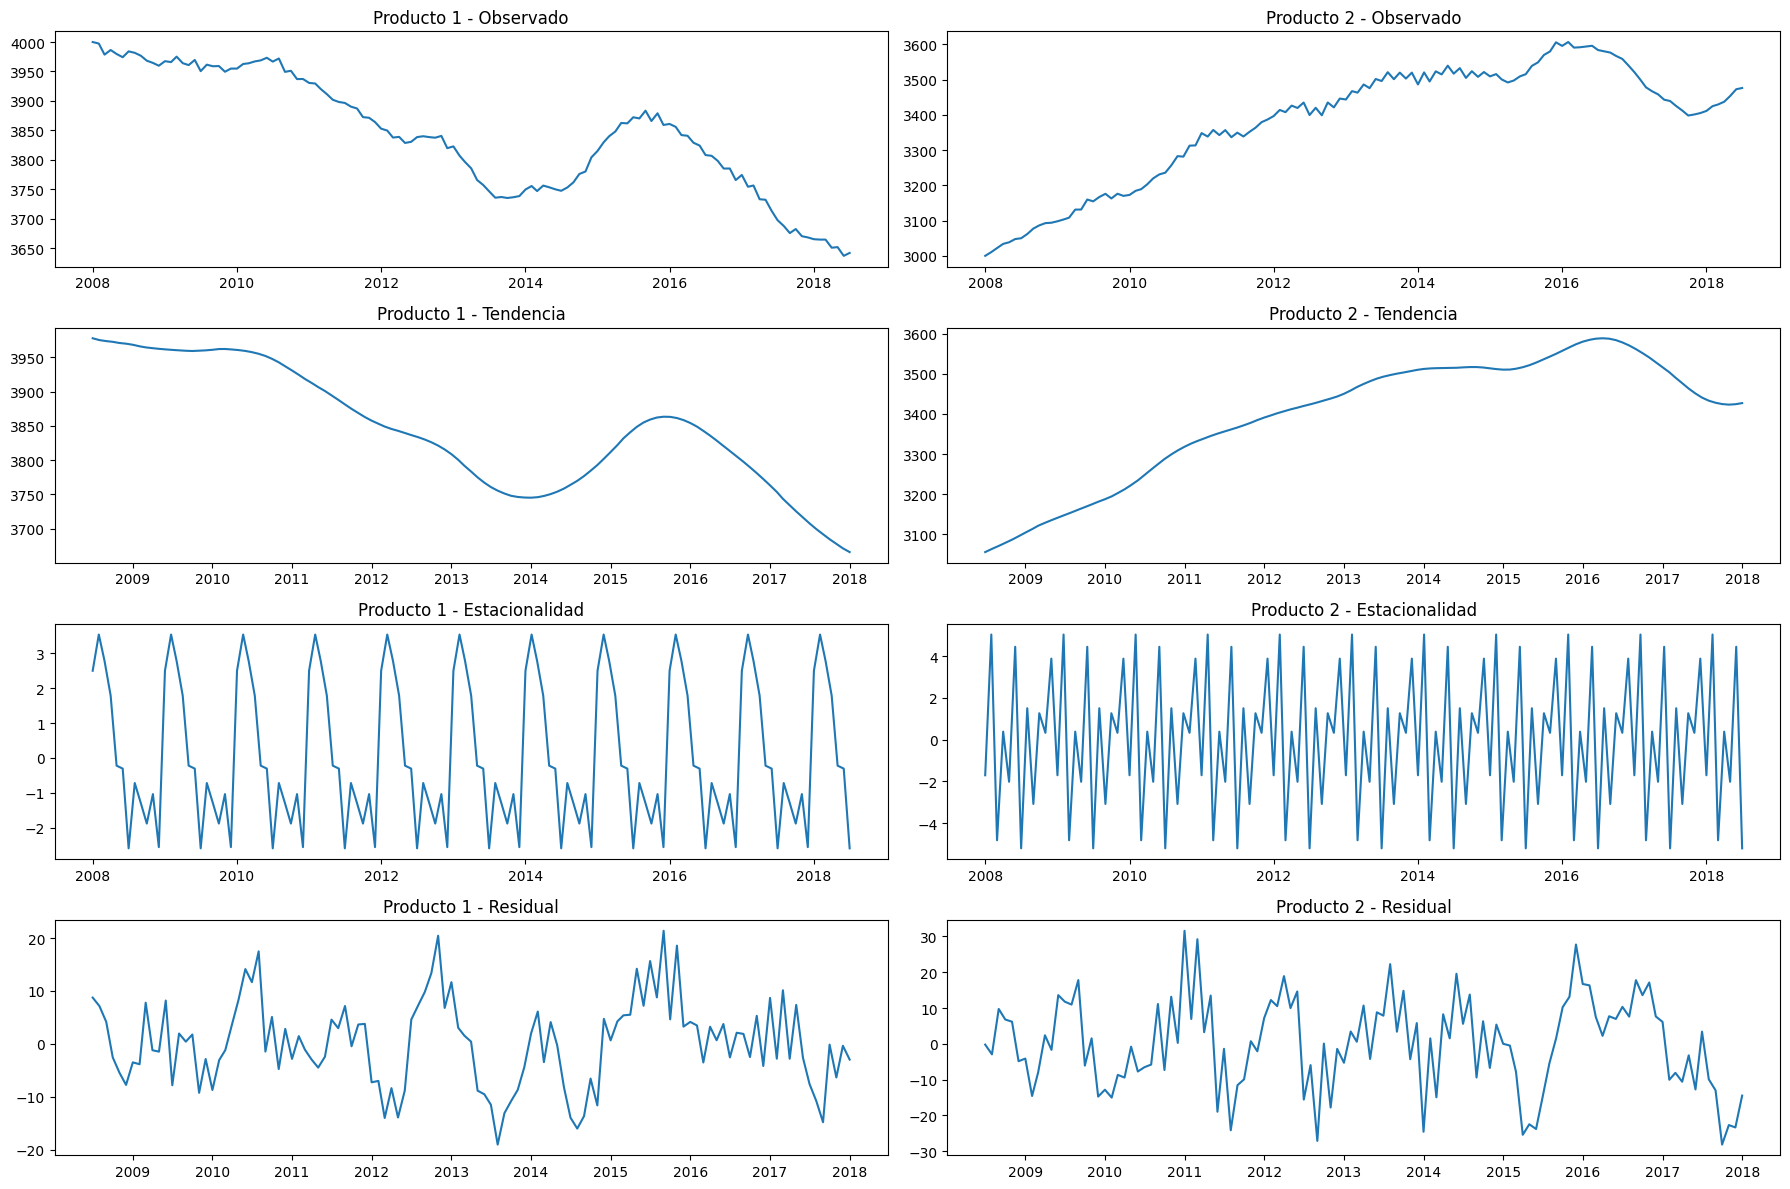

In [22]:
# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))

# Graficar los componentes de producto1
axes[0, 0].plot(td_componentes_producto1.observed)
axes[0, 0].set_title('Producto 1 - Observado')
axes[1, 0].plot(td_componentes_producto1.trend)
axes[1, 0].set_title('Producto 1 - Tendencia')
axes[2, 0].plot(td_componentes_producto1.seasonal)
axes[2, 0].set_title('Producto 1 - Estacionalidad')
axes[3, 0].plot(td_componentes_producto1.resid)
axes[3, 0].set_title('Producto 1 - Residual')

# Graficar los componentes de producto2
axes[0, 1].plot(td_componentes_producto2.observed)
axes[0, 1].set_title('Producto 2 - Observado')
axes[1, 1].plot(td_componentes_producto2.trend)
axes[1, 1].set_title('Producto 2 - Tendencia')
axes[2, 1].plot(td_componentes_producto2.seasonal)
axes[2, 1].set_title('Producto 2 - Estacionalidad')
axes[3, 1].plot(td_componentes_producto2.resid)
axes[3, 1].set_title('Producto 2 - Residual')

# Ajustar el layout
plt.tight_layout()
plt.show()

Aquí notamos que la tendencia de cada producto ha sido inversa es decir: el producto1 tiene una tendencia hacia la baja y el producto2 una tendencia a la alza; pero debemos observar que también a pesar de esto al final ambos prodcutos se encuentran en una ventas similares en cantidad aunque aún vende más el producto1. 

## **4. PROTOCOLOS DE EVALUACION**

Al inicio había hecho un train y test donde el test tenía solo el ultimo dato, pensando en los ejercicios anteriores.. NOta! 

### **4.1 Ventana Recursiva**

En un enfoque de ventana recursiva, entrenas el modelo con un conjunto de datos y luego lo usas para predecir un punto en el futuro. Después de obtener la predicción, amplías la ventana para incluir este nuevo punto y repites el proceso.

![alt text](recursive-window.png)

### **4.2 Rolling window**

En una rolling window, mueves la ventana a lo largo del tiempo para generar predicciones, entrenando el modelo solo en los datos más recientes.

![image.png](rolling-window.png)

Dependiendo del modelo a usar se deben hacer algunos ajustes a las funciones para el correcto funcionamiento del protocolo de evaluación

Se implementan las funciones para evaluar los modelos utilizando ambos protocolos.

In [28]:
# Calcular RMSE
def calculate_rmse(true_values, predictions):
    return np.sqrt(mean_squared_error(true_values, predictions))

# Evaluación con Ventana Recursiva
def recursive_window_evaluation(series, model_func, params, initial_train_size=12):
    predictions = []
    train = series[:initial_train_size].copy()
    
    for i in range(initial_train_size, len(series)):
        model = model_func(train, **params)
        if isinstance(model, pd.Series) and not model.empty:
            forecast = model.iloc[-1]  # Usar el último valor del promedio móvil
        else:
            forecast = train.iloc[-1]  # Si no hay suficientes datos para un promedio móvil, usar el último valor de entrenamiento
        predictions.append(forecast)
        # Concatenar el nuevo valor a la serie de entrenamiento
        train = pd.concat([train, series[i:i+1]])
    
    return predictions

# Evaluación con Rolling Window ajustada
def rolling_window_evaluation(series, model_func, params, window_size=12):
    predictions = []
    for i in range(window_size, len(series)):
        train = series[:i]
        test = series[i:i+1]
        
        model = model_func(train, **params)
        
        if isinstance(model, pd.Series) and not model.empty:
            forecast = model.iloc[-1]  # Usar el último valor del promedio móvil
        else:
            forecast = train.iloc[-1]  # Si no hay suficientes datos, usar el último valor de entrenamiento
        predictions.append(forecast)
    
    return predictions


## **5. MODELOS**

Implementaremos funciones para:

- Promedio Móvil.

- Suavización Exponencial (Simple, Holt, Holt-Winters).

- Regresion (Polinomios + Estacionalidad)

- ARIMA.

### **5.1 PROMEDIO MOVIL**

In [38]:
# Definir la función de promedio móvil
def moving_average_model(series, window):
    # Calcular el promedio móvil
    return series.rolling(window=window).mean()

# Función para evaluar el modelo de promedio móvil
def evaluate_moving_average(data, series_name, window, evaluation_protocol, initial_train_size=12, window_size=12):
    series = data[series_name]
    params = {'window': window}

    # Escoger el protocolo de evaluación
    if evaluation_protocol == 'recursive':
        predictions = recursive_window_evaluation(series, moving_average_model, params, initial_train_size=initial_train_size)
    elif evaluation_protocol == 'rolling':
        predictions = rolling_window_evaluation(series, moving_average_model, params, window_size=window_size)
    else:
        raise ValueError("El protocolo de evaluación debe ser 'recursive' o 'rolling'")
    
    # Calcular RMSE
    true_values = series[initial_train_size:] if evaluation_protocol == 'recursive' else series[window_size:]
    rmse = calculate_rmse(true_values, predictions)
    
    return rmse, predictions

# Definir el dataframe para almacenar los resultados
results_df = pd.DataFrame(columns=['Series', 'Window', 'Protocol', 'RMSE'])

# Función para evaluar diferentes ventanas y almacenar los resultados
def evaluate_moving_average_models(data, series_name, windows, protocols):
    for window in windows:
        for protocol in protocols:
            rmse, _ = evaluate_moving_average(data, series_name, window, evaluation_protocol=protocol)
            results_df.loc[len(results_df)] = [series_name, window, protocol, rmse]

# Listas de ventanas y protocolos a evaluar
windows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Puedes ajustar las ventanas que desees evaluar
protocols = ['recursive', 'rolling']

# Evaluar las series producto1 y producto2
evaluate_moving_average_models(data, 'producto1', windows, protocols)
evaluate_moving_average_models(data, 'producto2', windows, protocols)

# Seleccionar el mejor modelo para cada serie
def select_best_model(results_df, series_name):
    best_model = results_df[results_df['Series'] == series_name].sort_values(by='RMSE').iloc[0]
    return best_model

# Seleccionar el mejor modelo para producto1 y producto2
best_model_producto1 = select_best_model(results_df, 'producto1')
best_model_producto2 = select_best_model(results_df, 'producto2')


In [39]:
print(f"El mejor modelo para producto1 es:\n{best_model_producto1}\n")
print(f"El mejor modelo para producto2 es:\n{best_model_producto2}\n")


El mejor modelo para producto1 es:
Series      producto1
Window              1
Protocol    recursive
RMSE          9.99407
Name: 0, dtype: object

El mejor modelo para producto2 es:
Series      producto2
Window              2
Protocol    recursive
RMSE         16.12202
Name: 22, dtype: object



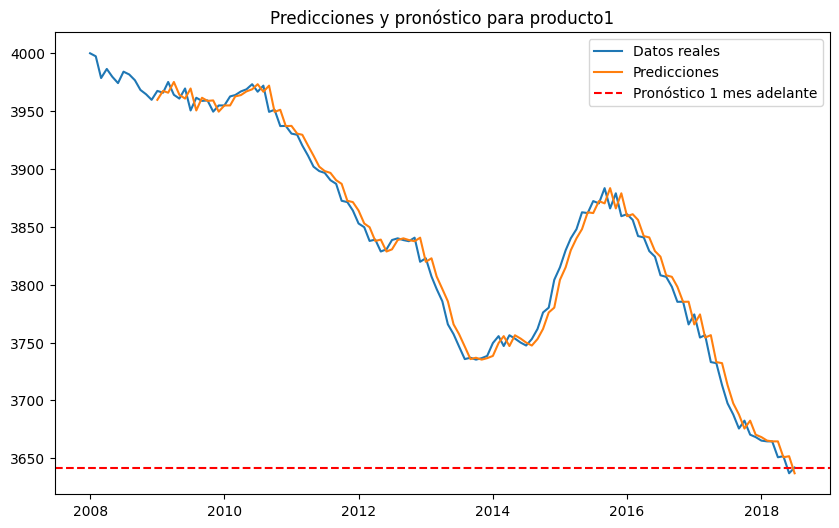

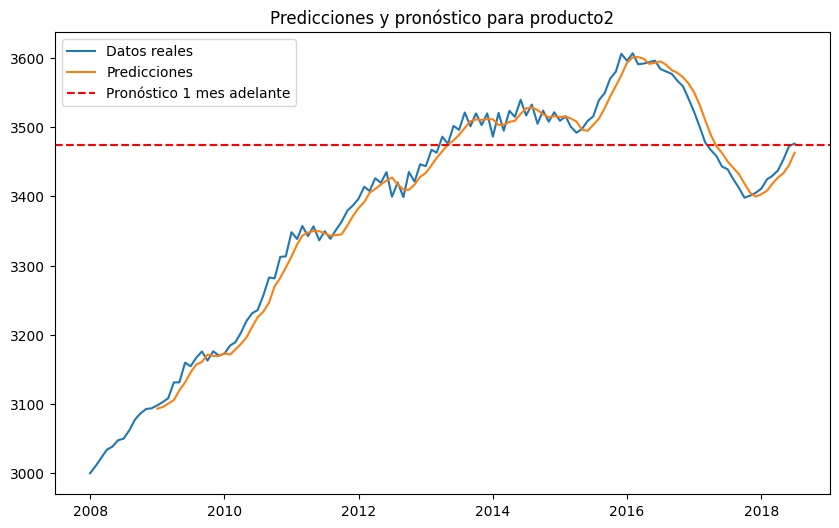

In [40]:
# Pronosticar un mes hacia adelante con el mejor modelo
def forecast_one_step_ahead(data, series_name, best_model):
    window = best_model['Window']
    series = data[series_name]
    model = moving_average_model(series, window)
    
    # Pronosticar el siguiente mes (último valor de la serie con promedio móvil)
    forecast = model.iloc[-1]  # Último valor del promedio móvil
    
    return forecast

# Pronóstico de un mes hacia adelante para producto1 y producto2
forecast_producto1 = forecast_one_step_ahead(data, 'producto1', best_model_producto1)
forecast_producto2 = forecast_one_step_ahead(data, 'producto2', best_model_producto2)


# Graficar las predicciones y pronósticos
def plot_predictions_and_forecast(series_name, predictions, forecast):
    plt.figure(figsize=(10, 6))
    series = data[series_name]
    plt.plot(series.index, series, label='Datos reales')
    plt.plot(series.index[len(series)-len(predictions):], predictions, label='Predicciones')
    plt.axhline(y=forecast, color='r', linestyle='--', label='Pronóstico 1 mes adelante')
    plt.title(f"Predicciones y pronóstico para {series_name}")
    plt.legend()
    plt.show()

# Obtener las predicciones con el mejor modelo
_, predictions_producto1 = evaluate_moving_average(data, 'producto1', best_model_producto1['Window'], best_model_producto1['Protocol'])
_, predictions_producto2 = evaluate_moving_average(data, 'producto2', best_model_producto2['Window'], best_model_producto2['Protocol'])

# Graficar los resultados para producto1
plot_predictions_and_forecast('producto1', predictions_producto1, forecast_producto1)

# Graficar los resultados para producto2
plot_predictions_and_forecast('producto2', predictions_producto2, forecast_producto2)


In [36]:
print(f"Pronóstico un mes adelante para producto1: {forecast_producto1}")
print(f"Pronóstico un mes adelante para producto2: {forecast_producto2}")


Pronóstico un mes adelante para producto1: 3641.99087267193
Pronóstico un mes adelante para producto2: 3474.293218407335
